In [1]:
!pip install -q sklearn

In [2]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [4]:
dftrain = pd.read_csv('https://raw.githubusercontent.com/Saketspradhan/Stock-Market-Analysis-System/main/fundamentally%20strong%20companies%20v3_train.csv')
dfeval = pd.read_csv('https://raw.githubusercontent.com/Saketspradhan/Stock-Market-Analysis-System/main/fundamentally%20strong%20companies%20v3_test.csv') 

In [5]:
dftrain.head()

,Name,CMP,Price_to_Earnings,Market_Capitalization,Dividend_Yield,Net_Profit_last_Quarter,YOY_Quarterly_Profit_Growth,Sales_last_Quarter,YOY_Quarterly_Sales_Growth,Return_on_Capital_Employed,Sales_Growth_3_Years,Profit_Growth_3_Years,Debt_to_Equity
0,Ksolves India,572.50,42.58,339.38,5.68,4.00,354.55,9.60,126.95,161.06,91.53,410.23,0.00
1,Nestle India,18273.30,79.70,176236.10,1.09,538.58,10.68,3476.70,13.97,139.29,10.07,19.34,0.07
2,Goenka Business,9.22,27.25,11.99,0.00,0.26,124.76,110.37,982.06,69.38,202.61,38.50,0.00
3,Tips Industries,1148.70,29.06,1510.21,0.13,14.58,139.80,28.12,87.72,64.57,23.99,140.63,0.00
4,Ajanta Soya,109.65,7.02,176.50,0.00,9.47,460.36,260.80,29.63,60.89,39.10,251.27,0.04


In [6]:
dfeval.head()

,Name,CMP,Price_to_Earnings,Market_Capitalization,Dividend_Yield,Net_Profit_last_Quarter,YOY_Quarterly_Profit_Growth,Sales_last_Quarter,YOY_Quarterly_Sales_Growth,Return_on_Capital_Employed,Sales_Growth_3_Years,Profit_Growth_3_Years,Debt_to_Equity
0,Vistar Amar,71.55,10.31,22.90,0.00,0.84,78.72,12.14,23.50,54.81,99.52,380.59,0.00
1,Chandra Pr. Intl,163.45,4.37,60.48,0.00,7.28,966.67,184.37,338.25,42.57,55.98,50.16,0.15
2,Godawari Power,1359.75,4.68,4801.48,1.36,434.87,835.41,1126.18,66.95,37.42,17.46,44.40,0.44
3,Paramone Concept,29.55,6.01,44.71,0.00,5.69,151.40,8.84,-74.29,34.65,37.54,92.07,0.81
4,Ajanta Pharma,2298.25,29.24,19881.52,0.41,173.75,17.59,747.99,11.94,31.95,10.78,11.83,0.01


In [7]:
y_train = dftrain.pop('CMP')
y_eval = dfeval.pop('CMP')

In [8]:
dftrain.describe()

,Price_to_Earnings,Market_Capitalization,Dividend_Yield,Net_Profit_last_Quarter,YOY_Quarterly_Profit_Growth,Sales_last_Quarter,YOY_Quarterly_Sales_Growth,Return_on_Capital_Employed,Sales_Growth_3_Years,Profit_Growth_3_Years,Debt_to_Equity
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,29.866948,7943.573247,0.385325,63.752857,535.153182,625.429740,117.474805,26.552208,30.706688,73.682597,0.170130
std,47.503574,21500.887172,1.011613,120.445538,1559.487004,1650.736611,285.437621,19.969396,33.209875,88.433414,0.226439
min,1.170000,2.350000,0.000000,-6.030000,10.680000,0.020000,-93.100000,0.780000,10.030000,10.420000,0.000000
25%,11.535000,79.972500,0.000000,1.392500,67.012500,15.547500,21.495000,14.685000,13.755000,31.650000,0.000000
50%,21.030000,810.250000,0.120000,12.245000,148.435000,114.325000,49.475000,22.405000,18.275000,46.335000,0.070000
75%,32.582500,5783.247500,0.427500,64.560000,382.270000,407.655000,115.272500,34.452500,36.117500,70.565000,0.237500
max,548.040000,176236.100000,10.270000,629.900000,12011.110000,15503.940000,2983.330000,161.060000,250.340000,735.210000,0.980000


In [9]:
dftrain.shape

(154, 12)

In [10]:
y_train.head()

0      572.50
1    18273.30
2        9.22
3     1148.70
4      109.65
Name: CMP, dtype: float64

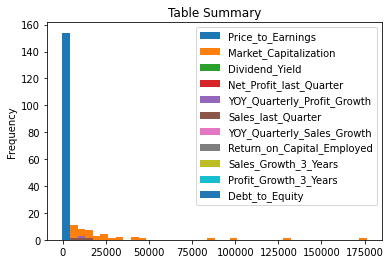

In [11]:
dftrain.plot(kind='hist', bins=40, title='Table Summary')

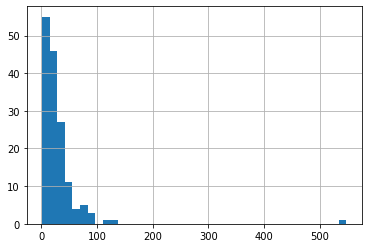

In [12]:
dftrain.Price_to_Earnings.hist(bins=40)

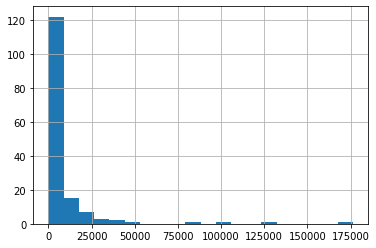

In [36]:
dftrain.Market_Capitalization.hist(bins=20)

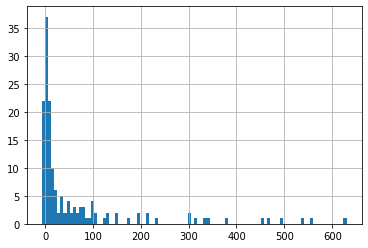

In [14]:
dftrain.Net_Profit_last_Quarter.hist(bins=100)

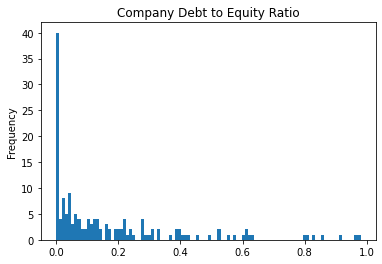

In [16]:
dftrain.Debt_to_Equity.plot(kind='hist', bins=100, title='Company Debt to Equity Ratio')

After analyzing this information, we should notice the following:
- A Linear trend is observed across the Price to Earnings' ratio with the exception of a few outliers
- Almost 2/3 companies have a Market Cap. of less than 25,000
- Most companies have a nearly 0 Debt to Equity Ratio



In [28]:
NUMERIC_COLUMNS = ['Price_to_Earnings', 'Market_Capitalization', 'Dividend_Yield', 'Net_Profit_last_Quarter', 'YOY_Quarterly_Profit_Growth', 'Sales_last_Quarter', 'YOY_Quarterly_Sales_Growth', 'Return_on_Capital_Employed', 'Sales_Growth_3_Years', 'Profit_Growth_3_Years', 'Debt_to_Equity']
feature_columns = []

for feature_name in NUMERIC_COLUMNS: feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

feature_columns

[NumericColumn(key='Price_to_Earnings', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Market_Capitalization', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Dividend_Yield', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Net_Profit_last_Quarter', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='YOY_Quarterly_Profit_Growth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Sales_last_Quarter', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='YOY_Quarterly_Sales_Growth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Return_on_Capital_Employed', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Sales_Growth_3_Years', shape=(1,), default_value=None, d

In [29]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

###Creating the Model
Now we are going to use a linear estimator to utilize the linear regression algorithm. 


In [30]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpbzeb4sip', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpupqmt1yp/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


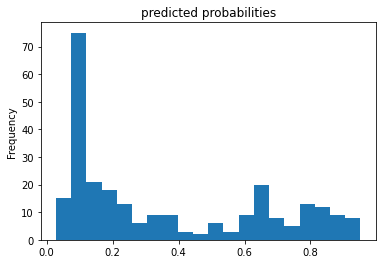

In [ ]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='Predicted Probabilities')